In [1]:
#!jupyter nbconvert --to script --no-prompt 1.0-load-IC-ROMS-data.ipynb

In [1]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

In [4]:
client

Connection method: Cluster object,Cluster type: SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.143:42423,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [7]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [8]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [9]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [10]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [11]:


def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='1D').mean('ocean_time')])
    print('done downsampling')
    return ds_workaround

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

In [12]:
timeRange = [8005, 8349]
datelist = np.array(range(timeRange[0],timeRange[1],4))

In [13]:

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessOnlyFirstDay(ds):
        '''leave only the first timestep in each file'''
        ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
        ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
        ds_workaround = ds_withtime.isel(ocean_time=0)
        return ds_workaround

    outNamePre = xr.open_mfdataset(filelist,chunks, preprocess=preprocessOnlyFirstDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right', combine='nested', concat_dim='ocean_time') 
    outNamePost= xr.open_dataset(filelist[0])
    outNameTimeLess = outNamePost.drop([ var for var in outNamePost.variables if     'ocean_time' in outNamePost[var].dims ])
    outName = xr.merge([outNamePre, outNameTimeLess])
    
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

In [14]:
## Load history data

filelist_SSHSST_fore=generateFileList(hisOSSEFilePath1,prefixForecast,datelist)
filelist_SSHSST_anal=generateFileList(hisOSSEFilePath1,prefixAnalysis,datelist)

filelist_SSHSST_XBT_fore=generateFileList(hisOSSEFilePath2,prefixForecast,datelist)
filelist_SSHSST_XBT_anal=generateFileList(hisOSSEFilePath2,prefixAnalysis,datelist)

filelist_SSHSST_XBT_N_fore=generateFileList(hisOSSEFilePath3,prefixForecast,datelist)
filelist_SSHSST_XBT_N_anal=generateFileList(hisOSSEFilePath3,prefixAnalysis,datelist)

filelist_SSHSST_XBT_S_fore=generateFileList(hisOSSEFilePath4,prefixForecast,datelist)
filelist_SSHSST_XBT_S_anal=generateFileList(hisOSSEFilePath4,prefixAnalysis,datelist)

OSSE_SSHSST_fore=loadOverlappedNetcdfFileList(hisOSSEFilePath1,prefixForecast,filelist=filelist_SSHSST_fore,overlapDays=7)
OSSE_SSHSST_anal=loadOverlappedNetcdfFileList(hisOSSEFilePath1,prefixAnalysis,filelist=filelist_SSHSST_anal,overlapDays=7)

OSSE_SSHSST_XBT_fore=loadOverlappedNetcdfFileList(hisOSSEFilePath2,prefixForecast,filelist=filelist_SSHSST_XBT_fore,overlapDays=7)
OSSE_SSHSST_XBT_anal=loadOverlappedNetcdfFileList(hisOSSEFilePath2,prefixAnalysis,filelist=filelist_SSHSST_XBT_anal,overlapDays=7)

OSSE_SSHSST_XBT_N_fore=loadOverlappedNetcdfFileList(hisOSSEFilePath3,prefixForecast,filelist=filelist_SSHSST_XBT_N_fore,overlapDays=7)
OSSE_SSHSST_XBT_N_anal=loadOverlappedNetcdfFileList(hisOSSEFilePath3,prefixAnalysis,filelist=filelist_SSHSST_XBT_N_anal,overlapDays=7)

OSSE_SSHSST_XBT_S_fore=loadOverlappedNetcdfFileList(hisOSSEFilePath4,prefixForecast,filelist=filelist_SSHSST_XBT_S_fore,overlapDays=7)
OSSE_SSHSST_XBT_S_anal=loadOverlappedNetcdfFileList(hisOSSEFilePath4,prefixAnalysis,filelist=filelist_SSHSST_XBT_S_anal,overlapDays=7)


# OSSE_SSHSST_XBT=loadOverlappedNetcdfFileList(hisOSSEFilePath2,prefixAnalysis, filelist=filelist_SSHSST_XBT,overlapDays=7)
# OSSE_SSHSST_XBT_N=loadOverlappedNetcdfFileList(hisOSSEFilePath3,prefixAnalysis, filelist=filelist_SSHSST_XBT_N,overlapDays=7)
# OSSE_SSHSST_XBT_S=loadOverlappedNetcdfFileList(hisOSSEFilePath4,prefixAnalysis, filelist=filelist_SSHSST_XBT_S,overlapDays=7)

loaded from /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer0_08005.nc to /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer0_08345.nc
loaded from /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08005.nc to /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08345.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer0_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer0_08345.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08345.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer0_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer0_08345.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08345.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOU

In [15]:
# process into more useful format
OSSE_SSHSST_fore = processROMSGrid(OSSE_SSHSST_fore)
OSSE_SSHSST_anal = processROMSGrid(OSSE_SSHSST_anal)

OSSE_SSHSST_XBT_fore = processROMSGrid(OSSE_SSHSST_XBT_fore)
OSSE_SSHSST_XBT_anal = processROMSGrid(OSSE_SSHSST_XBT_anal)

OSSE_SSHSST_XBT_N_fore = processROMSGrid(OSSE_SSHSST_XBT_N_fore)
OSSE_SSHSST_XBT_N_anal = processROMSGrid(OSSE_SSHSST_XBT_N_anal)

OSSE_SSHSST_XBT_S_fore = processROMSGrid(OSSE_SSHSST_XBT_S_fore)
OSSE_SSHSST_XBT_S_anal = processROMSGrid(OSSE_SSHSST_XBT_S_anal)


In [26]:
OSSE_SSHSST_XBT_N_fore.v_northward.shape

(86, 30, 317, 272)

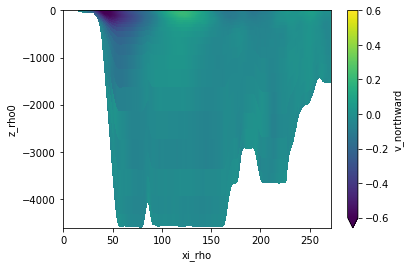

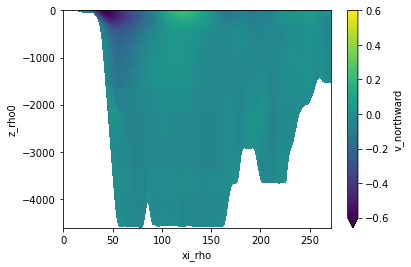

In [29]:
OSSE_SSHSST_XBT_N_fore["z_rho0"] = OSSE_SSHSST_XBT_N_fore.z_rho0.fillna(0)

OSSE_SSHSST_XBT_N_anal["z_rho0"] = OSSE_SSHSST_XBT_N_anal.z_rho0.fillna(0)

plt.figure()
OSSE_SSHSST_XBT_N_fore.v_northward.isel(eta_rho=315).mean(dim='ocean_time').plot(y='z_rho0',vmin=-.6,vmax=.6)
plt.figure()
OSSE_SSHSST_XBT_N_anal.v_northward.isel(eta_rho=315).mean(dim='ocean_time').plot(y='z_rho0',vmin=-.6,vmax=.6)

In [19]:
def process_incrementDS(fore,anal,vars):
    inc = (fore[vars[0]]-anal[vars[0]]).to_dataset()
    for var in vars[1:]:
        inc[var]=fore[var]-anal[var]
    return inc

incVars = ['temp','zeta','u','v']

OSSE_SSHSST_inc = process_incrementDS(OSSE_SSHSST_fore,OSSE_SSHSST_anal,incVars)
OSSE_SSHSST_XBT_inc = process_incrementDS(OSSE_SSHSST_XBT_fore,OSSE_SSHSST_XBT_anal,incVars)
OSSE_SSHSST_XBT_N_inc = process_incrementDS(OSSE_SSHSST_XBT_N_fore,OSSE_SSHSST_XBT_N_anal,incVars)
OSSE_SSHSST_XBT_S_inc = process_incrementDS(OSSE_SSHSST_XBT_S_fore,OSSE_SSHSST_XBT_S_anal,incVars)


In [20]:
# def process_removeTempDepth(ds):
#     ds_out = ds
#     ds_out['temp'] = ds.temp.isel(s_rho=-1)
#     return ds_out

# OSSE_SSHSST_inc = process_removeTempDepth(OSSE_SSHSST_inc)
# OSSE_SSHSST_XBT_inc = process_removeTempDepth(OSSE_SSHSST_XBT_inc)
# OSSE_SSHSST_XBT_N_inc = process_removeTempDepth(OSSE_SSHSST_XBT_N_inc)
# OSSE_SSHSST_XBT_S_inc = process_removeTempDepth(OSSE_SSHSST_XBT_S_inc)

In [21]:
def process_addBackTimelessVars(ds,ds_old):
    ds_timeless = ds_old.drop([ var for var in ds_old.variables if     'ocean_time' in ds_old[var].dims ])
    output = xr.merge([ds,ds_timeless])
    return output
    
OSSE_SSHSST_inc = process_addBackTimelessVars(OSSE_SSHSST_inc,OSSE_SSHSST_fore)
OSSE_SSHSST_XBT_inc = process_addBackTimelessVars(OSSE_SSHSST_XBT_inc,OSSE_SSHSST_XBT_fore)
OSSE_SSHSST_XBT_N_inc = process_addBackTimelessVars(OSSE_SSHSST_XBT_N_inc,OSSE_SSHSST_XBT_N_fore)
OSSE_SSHSST_XBT_S_inc = process_addBackTimelessVars(OSSE_SSHSST_XBT_S_inc,OSSE_SSHSST_XBT_S_fore)

In [22]:
# output Names
outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['OSSE_SSHSST_inc' ,'OSSE_SSHSST_XBT_inc','OSSE_SSHSST_XBT_N_inc','OSSE_SSHSST_XBT_S_inc']

outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'

In [ ]:
# # now save
# for var in expNames:
#     print('starting saving '+var)
#     ds = eval(var)
#     ds.load().to_netcdf(path=outputPath+outputPrefix+var+outputSuffix)
#     ds.close()
#     print('finished saving'+var)

# # truth.to_netcdf('/g/data/fu5/deg581/OSSE_analysis/data/proc/output_truth_8005_8041.nc')

starting saving OSSE_SSHSST_inc
finished savingOSSE_SSHSST_inc
starting saving OSSE_SSHSST_XBT_inc
finished savingOSSE_SSHSST_XBT_inc
starting saving OSSE_SSHSST_XBT_N_inc
finished savingOSSE_SSHSST_XBT_N_inc
starting saving OSSE_SSHSST_XBT_S_inc
